# Proyecto 04 - Informe Final de Carrera

Para este proyecto final, se decidió trabajar sobre el **Proyecto 03 - Procesamiento de Lenguaje Natural**. Dicho proyecto consiste en desarrollar un modelo que sea capaz de predecir una calificación en un sistema de estrellas a partir del comentario de ciertas reviews en amazon. El dataset utilizado es **The Multilingual Amazon Reviews Corpus**.

**El dataset se puede descargar en el siguiente [link](https://drive.google.com/uc?export=download&id=11XnXB7Ubgf3t6gotXGlM4FCwPOMHhDLX). Es un archivo .zip que contiene tres archivos. Para más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Este dataset cuenta con la siguiente [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt).**

Para consultar más detalle sobre este proyecto y el proyecto 03, se puede ingresar al siguiente repositorio en [Git](https://github.com/rickhm10/Proyectos-Acamica.git).

Inicialmente se obtienen más datos a través de **Web Scraping**. Cabe resaltar que los datos obtenidos no son una cantidad considerable, pero como ejercicio académico es un aporte valioso para el proyecto.


## Obtención Nuevos Datos - Web Scraping

### Incovenientes Encontrados al Realizar Web Scraping

En la página se tienen reviews en los cuales las personas colocaban el número de estrellas y título de la review pero no colocaban ningún comentario. Esto generó que la cantidad de registros en los comentarios no coinciera con las estrellas, lo cual dificultaba la obtención del dataset adicional.

Los comentarios en su fase incial se intentaron se extraer de la siguiente forma:

**for strong_tag in page.find_all('p', class_ = "review-content__text"):**

**listaDeComentarios.append(strong_tag.text)**

y las estrellas de la siguiente forma:

**for strong_tag in page.find_all('div', class_ = "star-rating star-rating--medium"):**

**listaDeEstrellas.append(strong_tag.select('img')[0]['alt'].split()[0])**
 
Para obtener los datos, se realizó de otra manera, la cual se encuentra plasmada en el código final.

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import json
import numpy as np
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [2]:
Comentarios_Amazon = []
patron = '<script data-initial-state="review-info" type="application/json">\n(.*)\n</script>'
arrayDePaginas = np.arange(1, 16) #Se toman 15 páginas de reviews

for x in arrayDePaginas:
    response = requests.get("https://es.trustpilot.com/review/www.amazon.com?page=" + str(x))
    page = BeautifulSoup(response.text,'html.parser')
    for strong_tag in page.find_all('div', class_ = "review-card"):
        Comentarios_Amazon.append(json.loads(re.findall(patron, str(strong_tag))[0]))

In [3]:
data_scraper = pd.json_normalize(Comentarios_Amazon)

### Análisis Exploratorio y Limpieza de Datos - Dataset Obtenido Mediante Web Scraping

In [4]:
data_scraper.shape

(300, 9)

In [5]:
data_scraper.isna().sum()

socialShareUrl             0
businessUnitId             0
businessUnitDisplayName    0
consumerId                 0
consumerName               0
reviewId                   0
reviewHeader               0
reviewBody                 0
stars                      0
dtype: int64

In [6]:
data_scraper.head(2)

,socialShareUrl,businessUnitId,businessUnitDisplayName,consumerId,consumerName,reviewId,reviewHeader,reviewBody,stars
0,https://es.trustpilot.com/reviews/60412a04f85d...,46ad346800006400050092d0,Amazon,60412a018a767c0019884474,Ernesto,60412a04f85d750394209bc3,Cuidado cada ves que hagan un reembolso…,Cuidado cada ves que hagan un reembolso a Amaz...,1
1,https://es.trustpilot.com/reviews/6036285df85d...,46ad346800006400050092d0,Amazon,5461d205000064000195b31c,Mariano Herrero,6036285df85d750b989f0ee7,No es lo que era,"Desde que no está Bezos, Amazon no es lo que e...",1


In [7]:
data = data_scraper[['reviewBody', 'stars']]

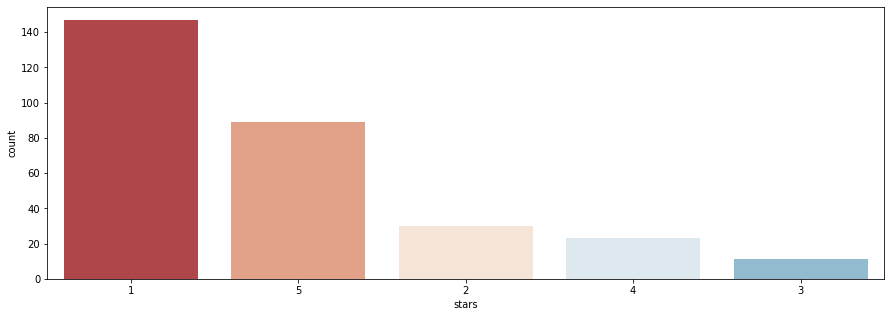

In [8]:
plt.figure(figsize = (15,5)) 
pal = sns.color_palette("RdBu")
sns.countplot(data=data, x="stars", order = data['stars'].value_counts().index, palette = pal)
plt.show()

Anteriormente se logró observar que se tienen **300** registros, y en el gráfico anterior se observa que para cada etiqueta, en este caso el número de estrellas del comentario, se tiene que la gran mayoría de comentarios tiene calificación de 1 y 5. Es decir el mayor porcentaje se encuentra en los extremos de la calificación. A diferencia del dataset de reviews de Amazon que se encuentra perfectamente balanceado, este dataset si está muy desbalanceado, pero al ser una cantidad de registros poco considerable con respecto a los **200000** registros del dataset de amazon, esto no alterará la forma como se abordó el modelo en el anterior proyecto, en cuanto a la selección de la métrica para trabajar.

Para continuar con nuestro análisis es necesario realizar una limpieza a los comentarios que se tienen, para ello utilizaremos el modelo para el idioma español de la librería **Spacy** y adicional utilizaremos una serie de funciones creadas mediante expresiones regulares que facilitarán este proceso de limpieza o normalización.

In [9]:
import spacy

nlp = spacy.load('es_core_news_sm')

Se crearon varias funciones que facilitarán el trabajo de limpieza o normalización:
* **eliminar_caracteres**: Tiene como objetivo reemplazar todos los caracteres que el usuario le indique por un espacio. Por defecto la función reemplaza todos los caracteres especiales y númericos.

* **eliminar_espacios**: Tiene como objetivo eliminar espacios, cuando existan más de uno. Por ejemplo, 'Hola  Mundo  ', al pasar por la función quedaría 'Hola Mundo'.

* **eliminar_stopwords**: Tiene como objetivo eliminar las palabras que se pasen en el segundo parámtero de la función. Se utilizará para eliminar palabras que no aporten mucha información en el comentario, esto es lo que se conoce como stopwords.

* **eliminar_palabras_longitud**: Tiene como objetivo eliminar las palabras que tengan menos de ciertos caracteres, los cuales se definen con el parámetro **longitud**, que por defecto viene en **3**. Adicional se puede indicar una lista de palabras para no eliminar, mediante el parámetro **excluir_palabra**, el cual por defecto excluye la palabra **no**. El último parámetro que trae esta función es **activar_exluir**, que por defecto viene en True, con False podemos indicarle que no se desea excluir ninguna palabra.

* **lemmatizar**: Tiene como objetivo realizar la lematización de las palabras. Para ello nos apoyamos de la librería Spacy.

* **eliminar_acentos**: Tiene como objetivo eliminar los acentos que se indiquen. Con el parámetro **acentos_eliminar** se indica los acentos que se desean eliminar, por defecto se eliminan las tildes en las vocales y la diéresis en la letra **u**. Con el parámetro **acentos_reemplazo**, se indica como quedaría el carácter sin el acento. Hay que resaltar que está función solo los valores por defecto se trabaja únicamente para las letras en minúscula.

* **crear_ngrams**: Tiene como objetivo crear ngrams, por defecto el parámetro **ngrams** es igual, lo cual indica que el texto se va a separar por palabra. Si se desea separar por dos palabras se debe pasar **ngrams** como igual a 2, y así sucesivamente.

In [10]:
def eliminar_caracteres(text, caracteres = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~¿¡1234567890'):
    return re.sub('[%s]' % re.escape(caracteres), ' ', text)

def eliminar_espacios(text):
    return " ".join(re.split("\s+", text, flags=re.UNICODE)).strip()

def eliminar_stopwords(text, stopwords):
    edit_string_as_list = text.split()
    final_list = [word for word in edit_string_as_list if word not in stopwords]
    return ' '.join(final_list)

def eliminar_palabras_longitud(text, longitud = 3, excluir_palabra = ['no'], activar_exluir = True):
    edit_string_as_list = text.split()
    if activar_exluir:
        words = [word for word in edit_string_as_list if word in excluir_palabra or len(word) > longitud]
    else:
        words = [word for word in edit_string_as_list if len(word) > longitud]
    return ' '.join(words)

def lemmatizar(text):
    edit_string_as_list = nlp(text)
    final_list = [word.lemma_ for word in edit_string_as_list]
    return ' '.join(final_list)

def eliminar_acentos(text, acentos_eliminar = 'áéíóúü', acentos_reemplazo = 'aeiouu'):
    trans = str.maketrans(acentos_eliminar,acentos_reemplazo)
    return text.translate(trans)

def crear_ngrams(text, ngrams=1):
    tokens = text.split()
    list_tokens = [tokens[i:i+ngrams] for i in range(len(tokens)-ngrams+1)]
    for i in range(len(list_tokens)):
        list_tokens[i] = ' '.join(list_tokens[i])
    return '##'.join(list_tokens)

In [11]:
STOP_WORDS = ['actualmente','acuerdo','adelante','ademas','además','adrede','afirmó','agregó','ahi','ahora','ahí','al','algo',
'alguna','algunas','alguno','algunos','algún','alli','allí','alrededor','ambos','ampleamos','antano','antaño','ante','anterior',
'antes','apenas','aproximadamente','aquel','aquella','aquellas','aquello','aquellos','aqui','aquél','aquélla','aquéllas',
'aquéllos','aquí','arriba','arriba','abajo','aseguró','asi','así','atras','aun','aunque','ayer','añadió','aún','bajo',
'bastante','bien','breve','buen','buena','buenas','bueno','buenos','cada','casi','cerca','cierta','ciertas','cierto','ciertos',
'cinco','claro','comentó','como','con','conmigo','conocer','conseguimos','conseguir','considera','consideró','consigo',
'consigue','consiguen','consigues','contigo','contra','cosas','creo','cual','cuales','cualquier','cuando','cuanta','cuantas',
'cuanto',
'cuantos','cuatro','cuenta','cuál','cuáles','cuándo','cuánta','cuántas','cuánto','cuántos','cómo','da','dado','dan','dar','de',
'debajo','debe','deben','debido','decir','dejó','del','delante','demasiado','demás','dentro','deprisa','desde','despacio',
'despues','después','detras','detrás','dia','dias','dice','dicen','dicho','dieron','diferente','diferentes','dijeron','dijo',
'dio','donde','dos','durante','día','días','dónde','ejemplo','el','ella','ellas','ello','ellos','embargo','empleais','emplean',
'emplear','empleas','empleo','en','encima','encuentra','enfrente','enseguida','entonces','entre','era','eramos','eran','eras',
'eres','es','esa','esas','ese','eso','esos','esta','estaba','estaban','estado','estados','estais','estamos','estan','estar',
'estará','estas','este','esto','estos','estoy','estuvo','está','están','ex','excepto','existe','existen','explicó','expresó',
'fin','final','fue','fuera','fueron','fui','fuimos','general','gran','grandes','gueno','ha','haber','habia','habla','hablan',
'habrá','había','habían','hace','haceis','hacemos','hacen','hacer','hacerlo','haces','hacia','haciendo','hago','han','hasta',
'hay','haya','he','hecho','hemos','hicieron','hizo','horas','hoy','hubo','igual','incluso','indicó','informo','informó',
'intenta','intentais','intentamos','intentan','intentar','intentas','intento','ir','junto','la','lado','largo','las','le',
'lejos','les','llegó','lleva','llevar','lo','los','luego','lugar','mal','manera','manifestó','mas','mayor','me','mediante',
'medio','mejor','mencionó','menos','menudo','mi','mia','mias','mientras','mio','mios','mis','misma','mismas','mismo','mismos',
'modo','momento','mucha','muchas','mucho','muchos','muy','más','mí','mía','mías','mío','míos','nada','nadie','ni','ninguna',
'ningunas','ninguno','ningunos','ningún','nos','nosotras','nosotros','nuestra','nuestras','nuestro','nuestros','nueva',
'nuevas','nuevo','nuevos','nunca','ocho','os','otra','otras','otro','otros','pais','para','parece','parte','partir','pasada',
'pasado','paìs','peor','pero','pesar','poca','pocas','poco','pocos','podeis','podemos','poder','podria','podriais','podriamos',
'podrian','podrias','podrá','podrán','podría','podrían','poner','por','porque','posible','primer','primera','primero',
'primeros','principalmente','pronto','propia','propias','propio','propios','proximo','próximo','próximos','pudo','pueda',
'puede','pueden','puedo','pues','qeu','que','quedó','queremos','quien','quienes','quiere','quiza','quizas','quizá','quizás',
'quién','quiénes','qué','raras','realizado','realizar','realizó','repente','respecto','sabe','sabeis','sabemos','saben','saber',
'sabes','salvo','se','sea','sean','segun','segunda','segundo','según','seis','ser','sera','será','serán','sería','señaló','si',
'sido','siempre','siendo','siete','sigue','siguiente','sin','sino','sobre','sois','sola','solamente','solas','solo','solos',
'somos','son','soy','soyos','su','supuesto','sus','suya','suyas','suyo','sé','sí','sólo','tal','tambien','también','tampoco',
'tan','tanto','tarde','te','temprano','tendrá','tendrán','teneis','tenemos','tener','tenga','tengo','tenido','tenía','tercera',
'ti','tiempo','tiene','tienen','toda','todas','todavia','todavía','todo','todos','total','trabaja','trabajais','trabajamos',
'trabajan','trabajar','trabajas','trabajo','tras','trata','través','tres','tu','tus','tuvo','tuya','tuyas','tuyo','tuyos','tú',
'ultimo','un','una','unas','uno','unos','usa','usais','usamos','usan','usar','usas','uso','usted','ustedes','va','vais','valor',
'vamos','van','varias','varios','vaya','veces','ver','verdad','verdadera','verdadero','vez','vosotras','vosotros','voy',
'vuestra','vuestras','vuestro','vuestros','ya','yo','él','ésa','ésas','ése','ésos','ésta','éstas','éste','éstos','última',
'últimas','último','últimos','o', 'no']

In [12]:
%%time
data.reviewBody = data.reviewBody.str.lower() #Convertir a Minuscula
data.reviewBody = data.reviewBody.apply(lambda x: eliminar_caracteres(x))
data.reviewBody = data.reviewBody.apply(lambda x: eliminar_espacios(x))
data.reviewBody = data.reviewBody.apply(lambda x: eliminar_stopwords(x,STOP_WORDS))
data.reviewBody = data.reviewBody.apply(lambda x: lemmatizar(x))
data.reviewBody = data.reviewBody.apply(lambda x: eliminar_acentos(x))
data.reviewBody = data.reviewBody.apply(lambda x: eliminar_palabras_longitud(x))

Wall time: 2.66 s


In [13]:
#Se crean varios dataframes con los comentarios para cada categoría de estrellas
stars1 = data[data.stars == 1]
stars2 = data[data.stars == 2]
stars3 = data[data.stars == 3]
stars4 = data[data.stars == 4]
stars5 = data[data.stars == 5]

Se hace necesario crear la función **words_frequency**, la cual tiene como objetivo devolvernos un dataframe con las palabras que aparezcan en todo el texto junto con su frecuencia, ordenado de las más frecuentes a las menos frecuentes.

Este análisis se realizará únicamente para unigramas dada la poca cantidad de reviews.

In [14]:
def words_frequency(text, ngrams=1):
    ngrams = text.apply(lambda x: crear_ngrams(x, ngrams=ngrams))
    stars_docs = '##'.join(ngrams)
    stars_freq = Counter(stars_docs.split("##"))
    df_stars = pd.DataFrame(list(stars_freq.items()), columns = ["Word","Frequency"])
    df_stars = df_stars[df_stars.Word != '']
    df_stars.sort_values('Frequency',ascending=False, inplace = True)
    return df_stars

In [15]:
df_stars1 = words_frequency(stars1.reviewBody)
df_stars2 = words_frequency(stars2.reviewBody)
df_stars3 = words_frequency(stars3.reviewBody)
df_stars4 = words_frequency(stars4.reviewBody)
df_stars5 = words_frequency(stars5.reviewBody)

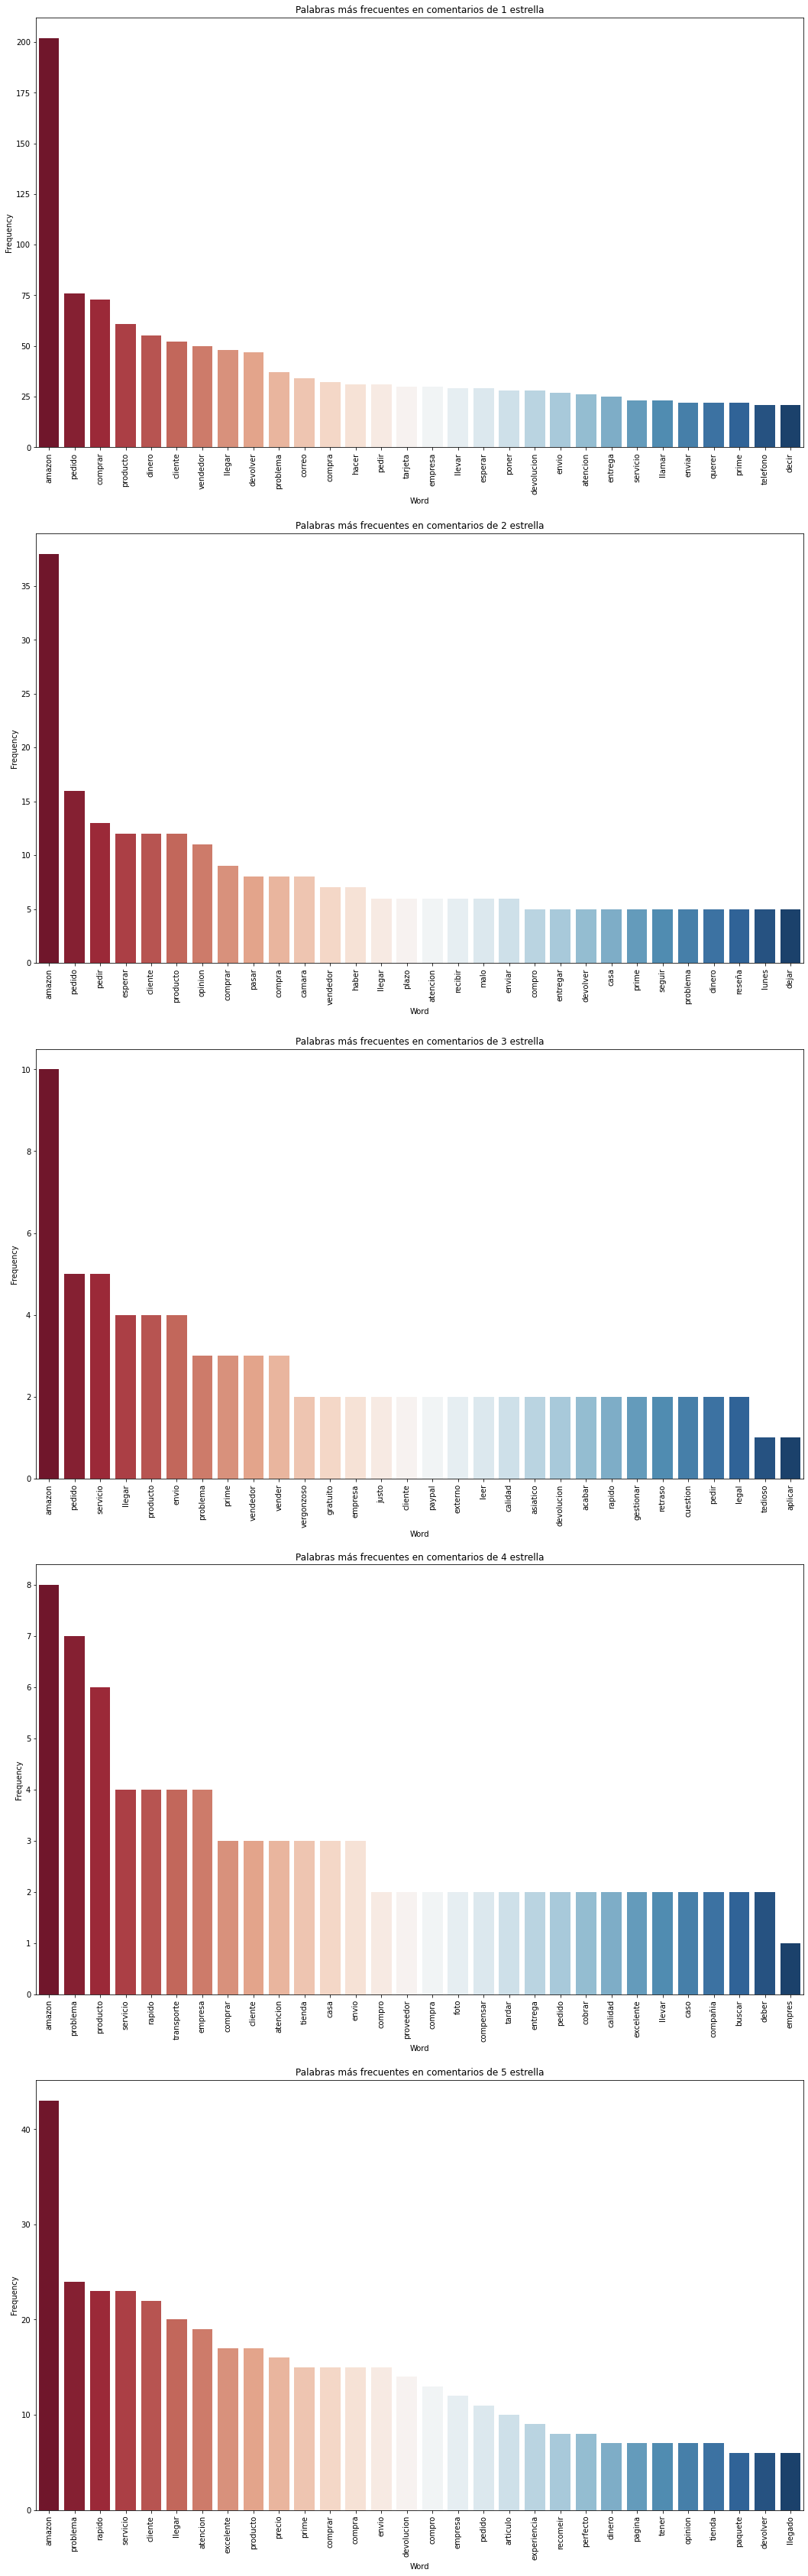

In [16]:
fig, axarr = plt.subplots(5, figsize=(18,60))

sns.barplot(x  = df_stars1.iloc[:30].Word, y = df_stars1.iloc[:30].Frequency, ax=axarr[0], palette="RdBu")
sns.barplot(x  = df_stars2.iloc[:30].Word, y = df_stars2.iloc[:30].Frequency, ax=axarr[1], palette="RdBu")
sns.barplot(x  = df_stars3.iloc[:30].Word, y = df_stars3.iloc[:30].Frequency, ax=axarr[2], palette="RdBu")
sns.barplot(x  = df_stars4.iloc[:30].Word, y = df_stars4.iloc[:30].Frequency, ax=axarr[3], palette="RdBu")
sns.barplot(x  = df_stars5.iloc[:30].Word, y = df_stars5.iloc[:30].Frequency, ax=axarr[4], palette="RdBu")

axarr[0].set_xticklabels(df_stars1.iloc[:30].Word, rotation='vertical')
axarr[1].set_xticklabels(df_stars2.iloc[:30].Word, rotation='vertical')
axarr[2].set_xticklabels(df_stars3.iloc[:30].Word, rotation='vertical')
axarr[3].set_xticklabels(df_stars4.iloc[:30].Word, rotation='vertical')
axarr[4].set_xticklabels(df_stars5.iloc[:30].Word, rotation='vertical')

axarr[0].title.set_text('Palabras más frecuentes en comentarios de 1 estrella')
axarr[1].title.set_text('Palabras más frecuentes en comentarios de 2 estrella')
axarr[2].title.set_text('Palabras más frecuentes en comentarios de 3 estrella')
axarr[3].title.set_text('Palabras más frecuentes en comentarios de 4 estrella')
axarr[4].title.set_text('Palabras más frecuentes en comentarios de 5 estrella')

fig.show()

En el anterior gráfico se visualiza las 30 palabras más frecuentes, para cada categoría de estrellas en los comentarios. Con ello se logra ver que algunas palabras son muy frecuentes en todas las categorías, lo cual realmente no apotaría información, incluso puede que generan confusiones al modelo al momento de intentar separar las clases. Por ello se crea otra lista de stopwords.

In [17]:
STOP_WORDS_1GRAM = ['no','producto','llegar','funcionar','comprar','calidad','venir','recomeir','quedar','problema','color',
                    'precio', 'amazon', 'paypal']

Para facilitar la limpieza o normalización de los comentarios, se crea la función **normalize**, la cual tiene como objetivo aplicar las funciones anteriormente creadas en un orden específico que permita una mejor limpieza.

In [18]:
def normalize(text, STOP_WORDS, activar_exluir = True):
    data = str.lower(text) #Convertir a Minuscula
    data = eliminar_caracteres(data)
    data = eliminar_espacios(data)
    data = eliminar_stopwords(data,STOP_WORDS)
    data = lemmatizar(data)
    data = eliminar_acentos(data)
    data = eliminar_palabras_longitud(data, activar_exluir = activar_exluir)
    return data

### Modelación

Para el **proyecto 03** nos entregaron 3 conjuntos de datos, el de **train** que utilizaremos para entrenar junto a los datos obtenidos mediante **web scraping**, el de **test** para optimizar los hiperparámetros de los modelos que utilicen y el de **dev** para realizar una pequeña simulación del modelo final en un ambiente productivo.

En el **proyecto 03** se logró observar que nuestros datos en train están perfectamente balanceados, y como los datos obtenidos mediante web scraping no son una cantidad considerable, se seguirá utilizando el **accuracy** como métrica para evaluar los modelos.

In [19]:
data_train = pd.read_json('data/dataset_es_train.json', lines=True)
data_test = pd.read_json('data/dataset_es_test.json', lines=True)

In [20]:
#Se concatenan data_train y los datos obtenidos mediante web scraping
data_train2 = data_scraper[['reviewBody', 'stars']]
data_train2 = data_train2.rename(columns={'reviewBody': 'review_body'})
data_train = pd.concat([data_train,data_train2])

In [21]:
data_train.shape

(200300, 8)

Se aplica la función **normalize** creada, para los conjuntos de datos de **train** y **test**.

In [22]:
%%time
data_train['review_normalize'] = data_train.review_body.apply(lambda x: normalize(x, STOP_WORDS+STOP_WORDS_1GRAM))
data_test['review_normalize'] = data_test.review_body.apply(lambda x: normalize(x, STOP_WORDS+STOP_WORDS_1GRAM))

Wall time: 19min 26s


In [23]:
data_train.head(2)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,review_normalize
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics,pantalla recibido respuesta fabricante
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics,horrible tener ingles informatico hora capaz i...


En el **proyecto 03** se evidenció que el performance del modelo mejora considerablemente al trabajarlo como un problema binario, para lo cual en este caso se trabajará únicamente con el problema en forma binaria.

Para convertir el problema en binario, se creará una nueva variable que indique si el comentario es positivo o no. Para crear dicha variable tomaremos los comentarios con 4 y 5 estrellas como comentarios positivos, y los comentarios con 1 y 2 estrellas como comentarios negativos. Los comentarios con 3 estrellas quedarán fuera del análisis dado que se consideran como comentarios neutrales.

In [24]:
data_train_binario = data_train[data_train.stars != 3]
data_test_binario = data_test[data_test.stars != 3]

In [25]:
data_train_binario = data_train_binario.reset_index(drop=True)
data_test_binario = data_test_binario.reset_index(drop=True)

In [26]:
data_train_binario['Ind_Positivo'] = np.where(data_train_binario.stars >= 4, 1, 0)
data_test_binario['Ind_Positivo'] = np.where(data_test_binario.stars >= 4, 1, 0)

In [27]:
X_train = data_train_binario['review_normalize']
y_train = data_train_binario['Ind_Positivo'].values

X_test = data_test_binario['review_normalize']
y_test = data_test_binario['Ind_Positivo'].values

### Modelo Benchmark - Support Vector Machine con Kernel Lineal

En este caso como modelo benchmark se trabajará con el mejor modelo obtenido en el **proyecto 03** para el problema. El cual fue con el algoritmo de **support vector machine con kernel lineal** y con los siguientes hiperparámetros **C = 0.1**, **penalty = 'l2'** y para la vectorización se utilizará **max_features = 2000**

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [29]:
%%time
vectorizer = CountVectorizer(max_features = 2000)
vectorizer.fit(X_train)

Wall time: 1.8 s


CountVectorizer(max_features=2000)

In [30]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

In [31]:
%%time
LinearSVM = LinearSVC(C = 0.1, penalty = 'l2', random_state = 42)
LinearSVM.fit(X_train, y_train)

Wall time: 11.4 s


LinearSVC(C=0.1, random_state=42)

In [32]:
y_train_pred_svm = LinearSVM.predict(X_train)
y_test_pred_svm = LinearSVM.predict(X_test)
accuracy_train_svm = accuracy_score(y_train, y_train_pred_svm)
accuracy_test_svm = accuracy_score(y_test, y_test_pred_svm)
print(f'Accuracy en Train: {round(accuracy_train_svm*100,2)}')
print(f'Accuracy en Test: {round(accuracy_test_svm*100,2)}')

Accuracy en Train: 83.67
Accuracy en Test: 82.65


In [33]:
print(classification_report(y_test, y_test_pred_svm))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      2000
           1       0.82      0.83      0.83      2000

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000



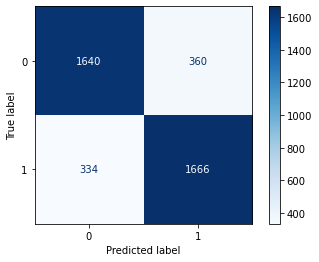

In [34]:
plot_confusion_matrix(LinearSVM, X_test, y_test, cmap=plt.cm.Blues, values_format = '.0f')
plt.show()

Comparando con los resultados obtenidos en el **proyecto 03** vemos que el performance con los datos agregados entregó prácticamente el mismo resultado, teníamos **82.6%** y ahora **82.65%** en el conjunto de test.

La idea en este proyecto es realizar un modelo implementando un nuevo algoritmo. En este caso se trabajará con una **Red Neuronal Standard**. Se implementará una red muy simple con solamente una capa oculta que tendrá 5 neuronas.

### Red Neuronal Standard

In [35]:
from keras.models import Sequential
from keras.layers import Dense

input_dim = X_train.shape[1]  #Número de características, que en este caso serían 2000 palabras definidas en el CountVectorizer

model = Sequential()
model.add(Dense(5, input_dim=input_dim, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Para la capa oculta se utilizó como función activadora **relu**, la cual en su concepto matemático implica llevar a cero todo valor negativo, y en términos prácticos esto significa apagar la neurona. Y para la capa de salida se trabajó con la función **sigmoid**, es bueno recordar que estas funciones activadoras tienen como función eliminar la linealidad que resulta de la suma producto que se ejecuta en cada neurona.

In [36]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 10005     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 10,011
Trainable params: 10,011
Non-trainable params: 0
_________________________________________________________________


En la anterior salida se observa la cantidad de parámetros que quedaron en nuestra red. Como entrada tenemos **2000** características, las cuales pasan por la capa oculta que tiene **5 neuronas**, de aquí tenemos **2000** multiplicado por **5** que sería **10000** y a esto se le suman los sesgos que resultados de cada neurona lo cual da **10005**, y en la neurona de la capa de salida, tenemos **5** entradas que se multiplican por 1 y se le adiciona el sesgo de dicha neurona, lo cual nos daría **6**. Y así tenemos un total de **10011** parámetros en nuestro red.

In [37]:
%%time
hist = model.fit(X_train, y_train, epochs=120, verbose=False, validation_data=(X_test, y_test), batch_size=10)

Wall time: 28min 10s


In [38]:
loss_train, accuracy_train = model.evaluate(X_train, y_train, verbose=False)
loss_test, accuracy_test = model.evaluate(X_test, y_test, verbose=False)
print(f'Accuracy en Train: {round(accuracy_train*100,2)}')
print(f'Accuracy en Test: {round(accuracy_test*100,2)}')

Accuracy en Train: 86.13
Accuracy en Test: 83.22


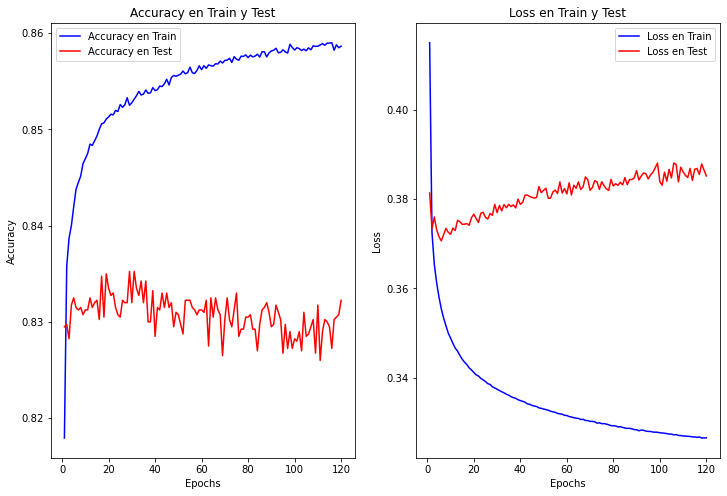

In [39]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
x = range(1, len(acc) + 1)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='Accuracy en Train')
plt.plot(x, val_acc, 'r', label='Accuracy en Test')
plt.title('Accuracy en Train y Test')
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Loss en Train')
plt.plot(x, val_loss, 'r', label='Loss en Test')
plt.title('Loss en Train y Test')
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.legend()
plt.show()

En la anterior gráfica se observa que la diferencia entre los resultados de **train** y **test** realmente no es tan grande, pero la forma en como se comporta el modelo en el conjunto de **test** a medida que crece el número de épocas da a entender que podemos estar enfrentándonos a un modelo con **overfitting**.

### Simulemos los modelos construidos como si estuviesen en productivo con el conjunto dev

In [40]:
data_dev = pd.read_json('data/dataset_es_dev.json', lines=True)

In [41]:
data_dev['review_normalize'] = data_dev.review_body.apply(lambda x: normalize(x, STOP_WORDS+STOP_WORDS_1GRAM))

In [42]:
data_dev_binario = data_dev[data_dev.stars != 3]
data_dev_binario['Ind_Positivo'] = np.where(data_dev_binario.stars >= 4, 1, 0)

In [43]:
X_dev = data_dev_binario['review_normalize']
y_dev = data_dev_binario['Ind_Positivo'].values

In [44]:
X_dev  = vectorizer.transform(X_dev)

### Suppor Vector Machine - Kernel Lineal

In [45]:
y_dev_pred_svm = LinearSVM.predict(X_dev)
accuracy_dev_svm = accuracy_score(y_dev, y_dev_pred_svm)
print(f'Accuracy en Dev: {round(accuracy_dev_svm*100,2)}')

Accuracy en Dev: 82.6


### Red Neuronal Standard

In [46]:
accuracy_dev_NN = model.evaluate(X_dev, y_dev, verbose=False)[1]
print(f'Accuracy en Dev: {round(accuracy_dev_NN*100,2)}')

Accuracy en Dev: 82.53


Comparando los resultados en el conjunto de **test** para los dos modelos aplicados, tenemos la **Red Neuronal Standard** con accuracy de **83.22%** y para **Support Vector Machine con Kernel Lineal** tenemos **82.65%**. Por temas de métricas podríamos decir que el modelo creado con la **Red Neuronal Standar** es un poco mejor. Pero si observamos los resultados en el conjunto de **dev**, se puede ver que le fue un poquito mejor al de **Support Vector Machine con Kernel Lineal**. Realmente no es una diferencia considerable, pero sigue estando latente que el modelo de creado con la **Red Neuronal** puede tener overfitting.

## Conclusiones

* La técnica de web scrapping, es muy poderosa y facilita mucho la obtención de nuevos datos que en muchas ocasiones no son de fácil acceso. Pero también implica un grado de responsabilidad y ética muy alto, a la hora de implementar dicha técnica.

* Un tema para investigar y profundizar, sería aplicar redes neuronales convulocionales, aplicar otro tipo de vectorización incluso realizando incrustaciones en nuestro corpus.

* Otro punto para investigar y probar si se puede combatir el tema de overfitting, es implementando técnicas de regularización en nuestra red neuronal.